# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   sudah dipastikan tidak memiliki label
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"dwilarassetyadita","key":"abeb338258e41ad032e7f743846a9850"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import zipfile, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import category_encoders as ce
from google.colab import files

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from category_encoders import BinaryEncoder
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [ ]:
# mendownload dataset yang akan digunakan
!kaggle datasets download -d valakhorasani/bank-transaction-dataset-for-fraud-detection -p /content/kaggle

Dataset URL: https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection
License(s): apache-2.0


In [ ]:
# mengekstrak data
local_zip = '/content/kaggle/bank-transaction-dataset-for-fraud-detection.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('kaggle')
zip_ref.close()

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [ ]:
# meninjau data
bank_transactions_df = pd.read_csv('/content/kaggle/bank_transactions_data_2.csv')
bank_transactions_df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [ ]:
# menilai data dan mencari data yang hilang
bank_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

- terdapat 16 kolom fitur
- tidak ditemukan missing value di dalam dataset

In [ ]:
# menampilkan statistik deskriptif dari dataset
bank_transactions_df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


- data terlihat normal dan tidak ada outlier

### Distribusi Data Numerik

In [ ]:
# pisahkan data numerik
numeric_cols = bank_transactions_df.select_dtypes(include=['int64', 'float64']).columns

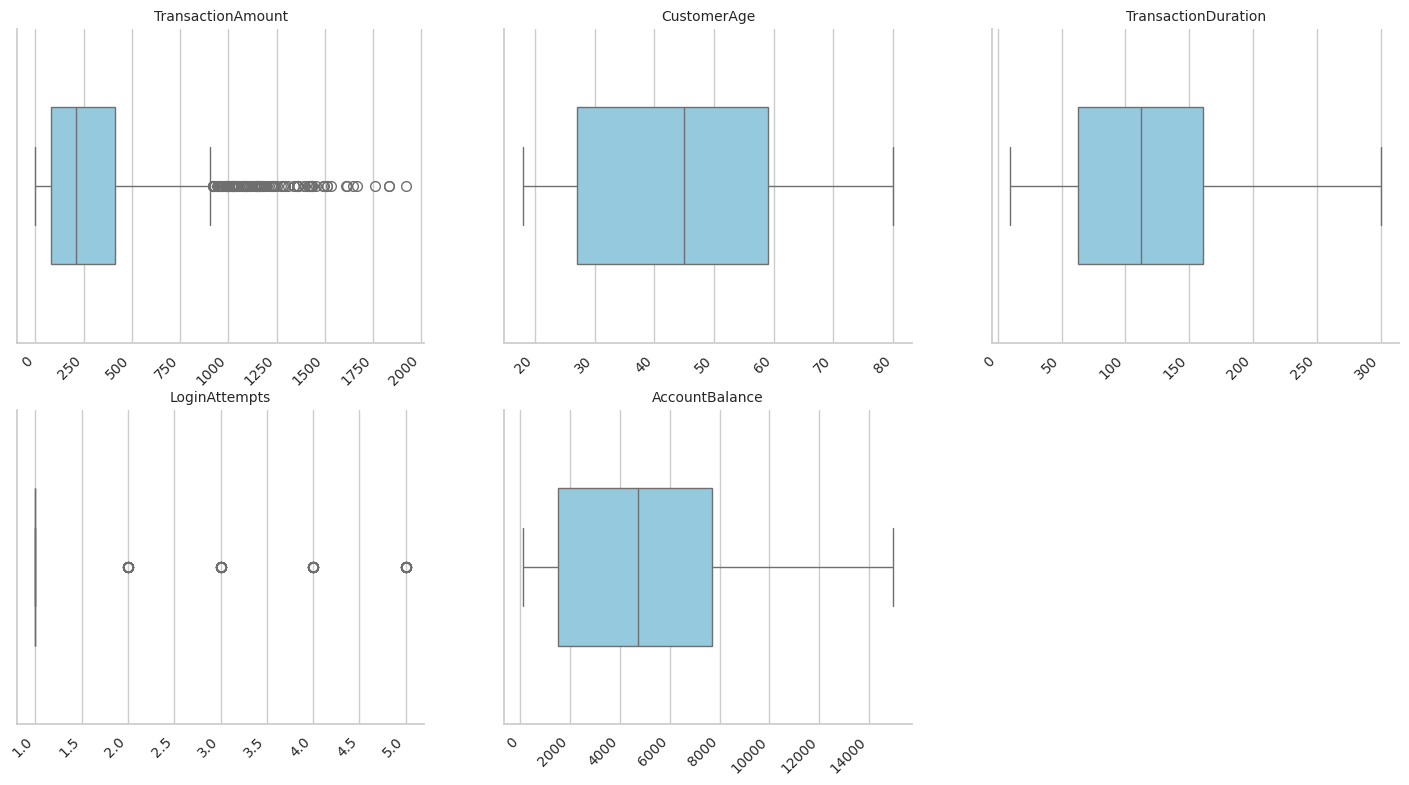

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 9

n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

# Buat figure besar dengan grid 2x3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
fig.tight_layout(pad=3.0)

# Looping setiap kolom
for i, feature in enumerate(numeric_cols):
    ax = axes[i//n_cols, i%n_cols] if n_rows > 1 else axes[i%n_cols]

    sns.boxplot(
        x=bank_transactions_df[feature],
        color='skyblue',
        width=0.5,
        linewidth=1,
        ax=ax
    )

    ax.set_title(feature, fontsize=10)
    ax.set_xlabel('')


    ax.ticklabel_format(style='plain', axis='x')


    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Hilangkan subplot yang kosong
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes.flatten()[j])

sns.despine()
plt.show()

- data terlihat terdistribusi secara tidak normal
- data dari kolom TransactionAmount dan kolom LoginAttempts terdistribusi sangat tidak normal

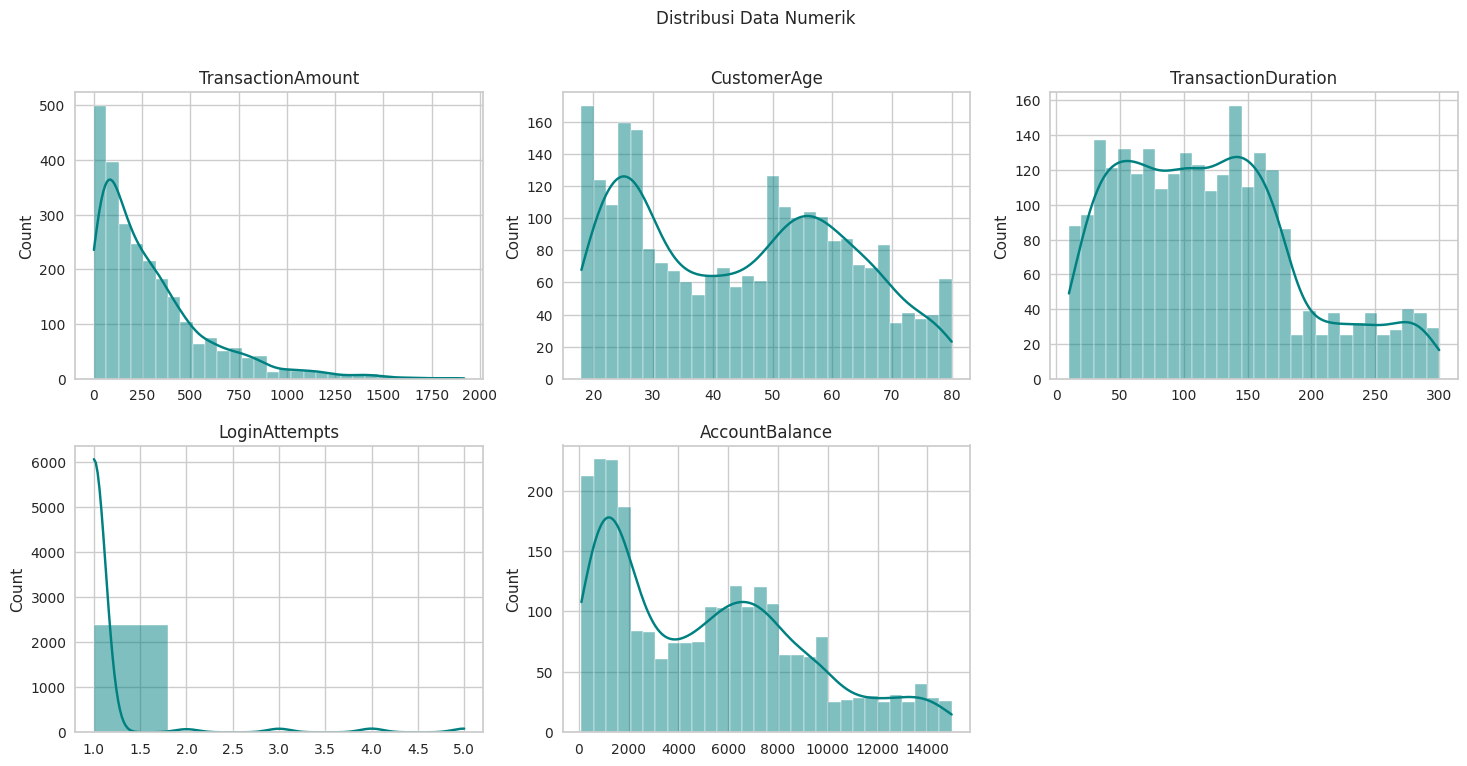

In [ ]:
# Membuat histogram untuk kolom numerik
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.suptitle('Distribusi Data Numerik', fontsize=12)
plt.tight_layout(pad=3.0)

# Looping untuk setiap kolom numerik
for i, kolom in enumerate(numeric_cols):
    baris = i // 3
    kolom_pos = i % 3

    # menghitung jumlah bins secara otomatis
    bins = 20
    if len(bank_transactions_df[kolom].unique()) > 1:
        bins = min(30, len(bank_transactions_df[kolom].unique()))  # Maksimal 30 bins


    sns.histplot(
        data=bank_transactions_df[kolom],
        bins=bins,
        kde=True,  # Tambahkan garis kurva
        color='teal',
        ax=axes[baris, kolom_pos]
    )

    # mengatur tampilan plot
    axes[baris, kolom_pos].set_title(kolom)
    axes[baris, kolom_pos].set_xlabel('')

    # menyembunyikan subplot yang tidak terpakai
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes.flatten()[j])

plt.show()


- data data yang disajikan memiliki distribusi yang cenderung tidak normal
- namun untuk data transaksi, hal tersebut dinilai sangat sering terjadi dan tidak dianggap sebagai outliers


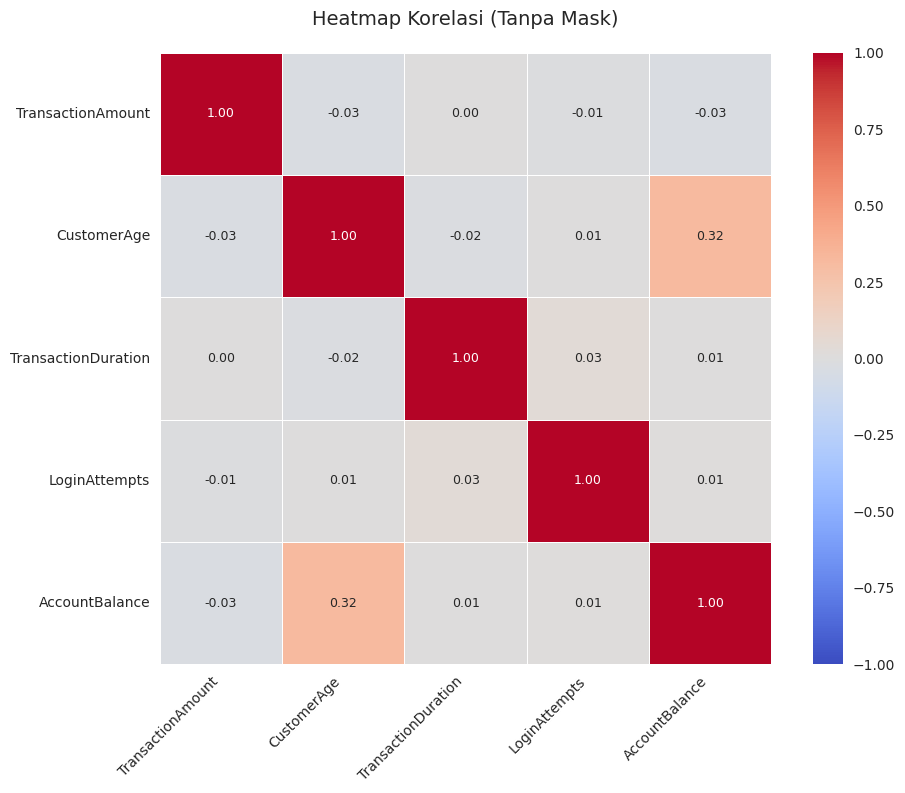

In [ ]:
numeric_data = bank_transactions_df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_data.corr()

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5
)


plt.title('Heatmap Korelasi (Tanpa Mask)', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

- tidak ada kolom yang memiliki korelasi terlalu tinggi dengan kolom lainnya

### Distribusi Data Kategorikal

In [ ]:
# memisahkan data kategorikal
cat_cols = bank_transactions_df.select_dtypes(include=['object'])
cat_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   TransactionID            2512 non-null   object
 1   AccountID                2512 non-null   object
 2   TransactionDate          2512 non-null   object
 3   TransactionType          2512 non-null   object
 4   Location                 2512 non-null   object
 5   DeviceID                 2512 non-null   object
 6   IP Address               2512 non-null   object
 7   MerchantID               2512 non-null   object
 8   Channel                  2512 non-null   object
 9   CustomerOccupation       2512 non-null   object
 10  PreviousTransactionDate  2512 non-null   object
dtypes: object(11)
memory usage: 216.0+ KB


In [ ]:
def counts_cat_cols(data, col):
  count_col = data[col].value_counts()
  top_n = 10
  top_value = count_col[:top_n]
  other_value = count_col[top_n:].sum()
  top_value = pd.concat([top_value, pd.Series({'Other': other_value})])
  return top_value

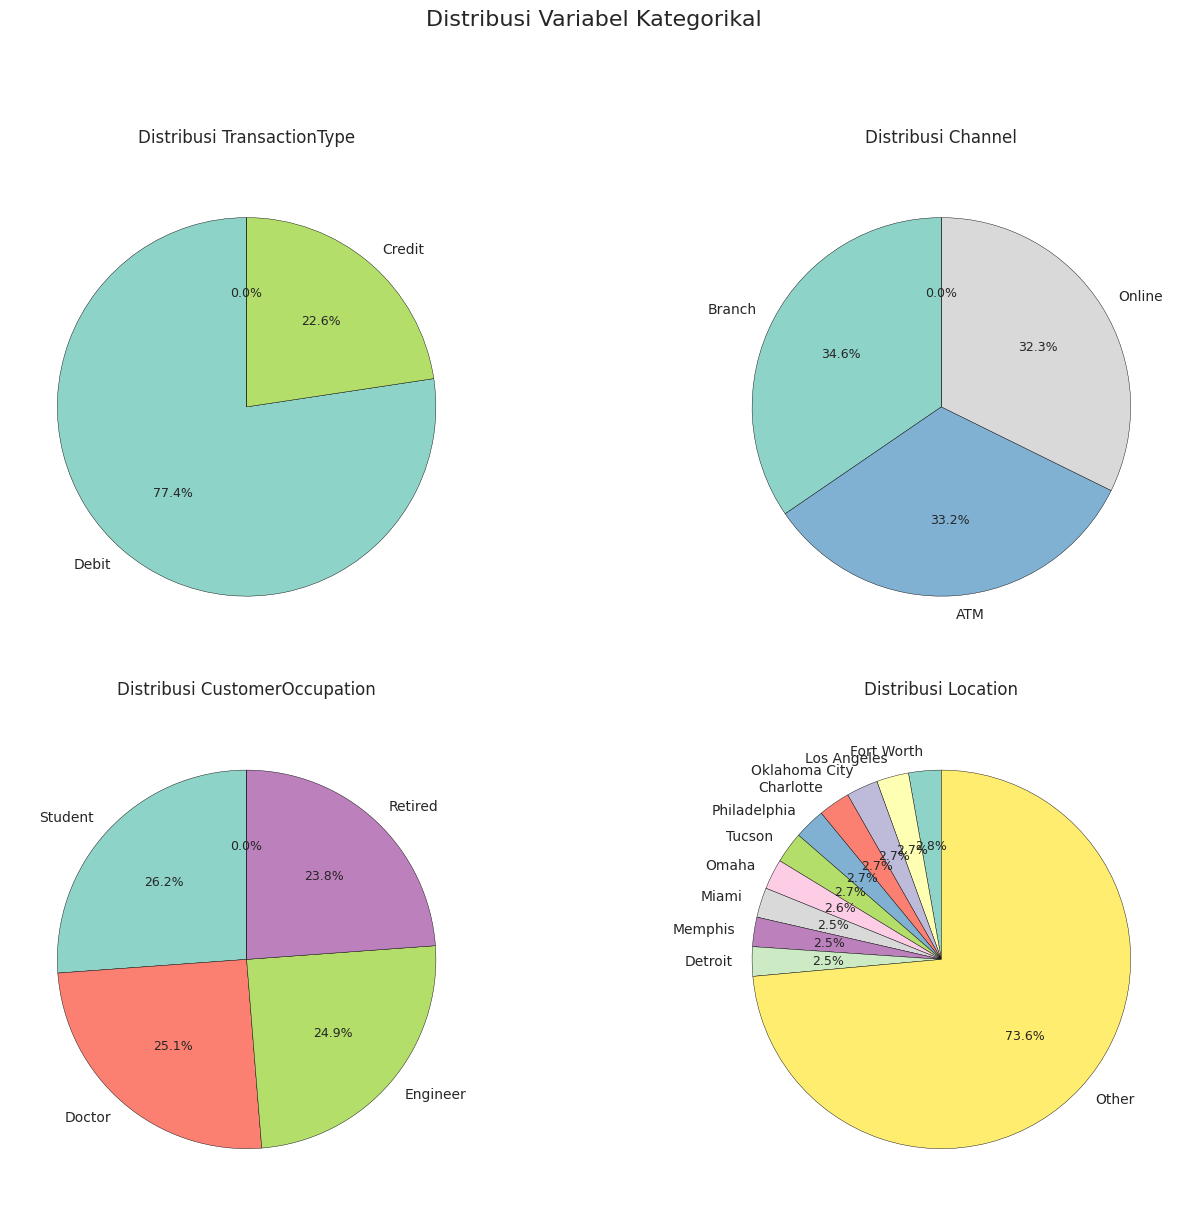

In [ ]:
# Persiapan Data
columns_to_plot = ['TransactionType', 'Channel', 'CustomerOccupation', 'Location']
data_counts = {col: counts_cat_cols(bank_transactions_df, col) for col in columns_to_plot}

#  Setup Grid Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribusi Variabel Kategorikal', fontsize=16, y=1.02)
axes = axes.ravel()

# Plotting di Setiap Subplot
for i, (col, count_data) in enumerate(data_counts.items()):
    count_data.plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=90,
        cmap='Set3',
        wedgeprops={'edgecolor': 'black'},
        ax=axes[i]
    )
    axes[i].set_title(f'Distribusi {col}', pad=20)
    axes[i].set_ylabel('')

# Adjust Layout
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
TransactionType_unique = bank_transactions_df['TransactionType'].unique()
print(TransactionType_unique)

['Debit' 'Credit']


In [ ]:
Channel_unique = bank_transactions_df['Channel'].unique()
print(Channel_unique)

['ATM' 'Online' 'Branch']


In [ ]:
CustomerOccupation_unique = bank_transactions_df['CustomerOccupation'].unique()
print(CustomerOccupation_unique)

['Doctor' 'Student' 'Retired' 'Engineer']


In [ ]:
Location_unique = bank_transactions_df['Location'].unique()
print(Location_unique)

['San Diego' 'Houston' 'Mesa' 'Raleigh' 'Atlanta' 'Oklahoma City'
 'Seattle' 'Indianapolis' 'Detroit' 'Nashville' 'Albuquerque' 'Memphis'
 'Louisville' 'Denver' 'Austin' 'Columbus' 'Los Angeles' 'Las Vegas'
 'Fort Worth' 'Miami' 'Milwaukee' 'Baltimore' 'New York' 'San Francisco'
 'San Jose' 'San Antonio' 'Philadelphia' 'Charlotte' 'Tucson' 'Chicago'
 'Sacramento' 'Kansas City' 'Omaha' 'Virginia Beach' 'Dallas' 'Boston'
 'Jacksonville' 'Phoenix' 'Washington' 'El Paso' 'Colorado Springs'
 'Fresno' 'Portland']


# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [ ]:
# membuat dataframe baru
cleaned_df = bank_transactions_df.copy()

In [ ]:
# menghapus kolom dengan varians terlalu besar
cleaned_df.drop(columns=['TransactionID', 'AccountID', 'Location', 'DeviceID', 'IP Address','MerchantID'], inplace=True)

### Handeling data date

In [ ]:
# transformasi data tanggal
cleaned_df['TransactionDate'] = pd.to_datetime(bank_transactions_df['TransactionDate'])
cleaned_df['PreviousTransactionDate'] = pd.to_datetime(bank_transactions_df['PreviousTransactionDate'])

In [ ]:
# Ekstrak komponen waktu
cleaned_df['trans_year'] = cleaned_df['TransactionDate'].dt.year
cleaned_df['trans_month'] = cleaned_df['TransactionDate'].dt.month
cleaned_df['trans_day'] = cleaned_df['TransactionDate'].dt.day
cleaned_df['trans_hour'] = cleaned_df['TransactionDate'].dt.hour
cleaned_df['trans_dayofweek'] = cleaned_df['TransactionDate'].dt.dayofweek


In [ ]:
# Hitung selisih jam (float)
cleaned_df['hours_since_last_trans'] = (
    cleaned_df['TransactionDate'] - cleaned_df['PreviousTransactionDate']
).dt.total_seconds() / 3600

# hapus data
cleaned_df.drop(columns=['TransactionDate', 'PreviousTransactionDate'], inplace=True)

In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TransactionAmount       2512 non-null   float64
 1   TransactionType         2512 non-null   object 
 2   Channel                 2512 non-null   object 
 3   CustomerAge             2512 non-null   int64  
 4   CustomerOccupation      2512 non-null   object 
 5   TransactionDuration     2512 non-null   int64  
 6   LoginAttempts           2512 non-null   int64  
 7   AccountBalance          2512 non-null   float64
 8   trans_year              2512 non-null   int32  
 9   trans_month             2512 non-null   int32  
 10  trans_day               2512 non-null   int32  
 11  trans_hour              2512 non-null   int32  
 12  trans_dayofweek         2512 non-null   int32  
 13  hours_since_last_trans  2512 non-null   float64
dtypes: float64(3), int32(5), int64(3), objec

In [ ]:
cleaned_df.head()

,TransactionAmount,TransactionType,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,trans_year,trans_month,trans_day,trans_hour,trans_dayofweek,hours_since_last_trans
0,14.09,Debit,ATM,70,Doctor,81,1,5112.21,2023,4,11,16,1,-13743.648333
1,376.24,Debit,ATM,68,Doctor,141,1,13758.91,2023,6,27,16,1,-11895.421111
2,126.29,Debit,Online,19,Student,56,1,1122.35,2023,7,10,18,0,-11581.848889
3,184.50,Debit,Online,26,Student,25,1,8569.06,2023,5,5,16,4,-13167.615278
4,13.45,Credit,Online,26,Student,198,1,7429.40,2023,10,16,17,0,-9230.254167


In [ ]:
bank_transactions_df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


### Standarisasi kolom-kolom numerik

In [ ]:
cols_to_scale = ['TransactionAmount', 'TransactionDuration', 'AccountBalance', 'hours_since_last_trans']
scaler = StandardScaler()
cleaned_df[cols_to_scale] = scaler.fit_transform(cleaned_df[cols_to_scale])


### encoding kolom kategorikal

In [ ]:
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
ohe_data = ohe.fit_transform(cleaned_df[['TransactionType', 'trans_year']])
ohe_cols = ohe.get_feature_names_out(['TransactionType', 'trans_year'])
ohe_df = pd.DataFrame(ohe_data, columns=ohe_cols)
cleaned_df = pd.concat([cleaned_df.reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1)

In [ ]:
bin_encoder_channel = ce.BinaryEncoder(cols=['Channel'])
bin_channel = bin_encoder_channel.fit_transform(cleaned_df[['Channel']])
cleaned_df = pd.concat([cleaned_df.reset_index(drop=True), bin_channel.reset_index(drop=True)], axis=1)

In [ ]:
bin_encoder_occ = ce.BinaryEncoder(cols=['CustomerOccupation'])
bin_occ = bin_encoder_occ.fit_transform(cleaned_df[['CustomerOccupation']])
cleaned_df = pd.concat([cleaned_df.reset_index(drop=True), bin_occ.reset_index(drop=True)], axis=1)

In [ ]:
cols_to_encode = ['TransactionType', 'Channel', 'CustomerOccupation', 'trans_year']

In [ ]:
# menghapus kolom" sebelum di encodind
cleaned_df.drop(columns=cols_to_encode, inplace=True)

In [ ]:
cleaned_df.head()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,trans_month,trans_day,trans_hour,trans_dayofweek,hours_since_last_trans,TransactionType_Debit,trans_year_2024,Channel_0,Channel_1,CustomerOccupation_0,CustomerOccupation_1,CustomerOccupation_2
0,-0.971275,70,-0.552443,1,-0.000537,4,11,16,1,-0.800762,1.0,0.0,0,1,0,0,1
1,0.269440,68,0.305314,1,2.216472,6,27,16,1,-0.076706,1.0,0.0,0,1,0,0,1
2,-0.586882,19,-0.909842,1,-1.023534,7,10,18,0,0.046138,1.0,0.0,1,0,0,1,0
3,-0.387456,26,-1.353017,1,0.885797,5,5,16,4,-0.575097,1.0,0.0,1,0,0,1,0
4,-0.973468,26,1.120184,1,0.593589,10,16,17,0,0.967391,0.0,0.0,1,0,0,1,0


In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TransactionAmount       2512 non-null   float64
 1   CustomerAge             2512 non-null   int64  
 2   TransactionDuration     2512 non-null   float64
 3   LoginAttempts           2512 non-null   int64  
 4   AccountBalance          2512 non-null   float64
 5   trans_month             2512 non-null   int32  
 6   trans_day               2512 non-null   int32  
 7   trans_hour              2512 non-null   int32  
 8   trans_dayofweek         2512 non-null   int32  
 9   hours_since_last_trans  2512 non-null   float64
 10  TransactionType_Debit   2512 non-null   float64
 11  trans_year_2024         2512 non-null   float64
 12  Channel_0               2512 non-null   int64  
 13  Channel_1               2512 non-null   int64  
 14  CustomerOccupation_0    2512 non-null   

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [ ]:
x_model = cleaned_df.copy()

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=25, random_state=42)
kmeans_labels = kmeans.fit_predict(x_model)

x_model['Cluster'] = kmeans_labels
print(x_model['Cluster'].value_counts())

Cluster
1    1035
0     808
2     669
Name: count, dtype: int64


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

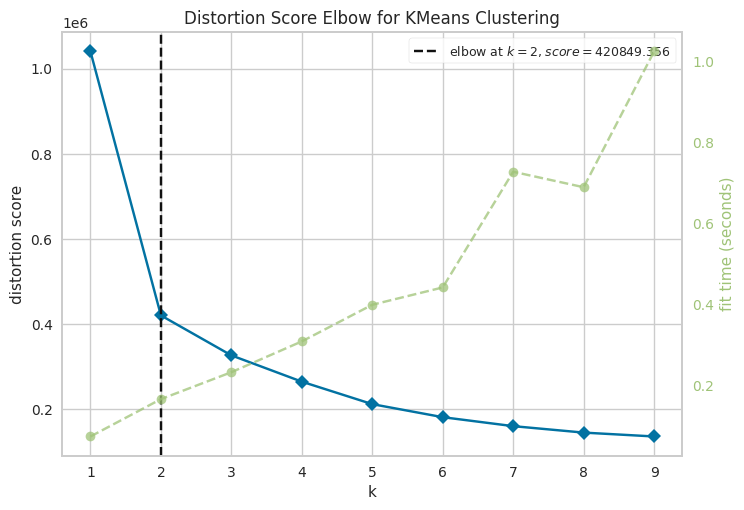

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Inisialisasi visualizer KElbow untuk menentukan jumlah cluster optimal
visualizer = KElbowVisualizer(kmeans, k=(1, 10))

# Fit visualizer dengan data yang sudah diskalakan 
visualizer.fit(x_model) 

# Menampilkan grafik elbow untuk analisis
visualizer.show()


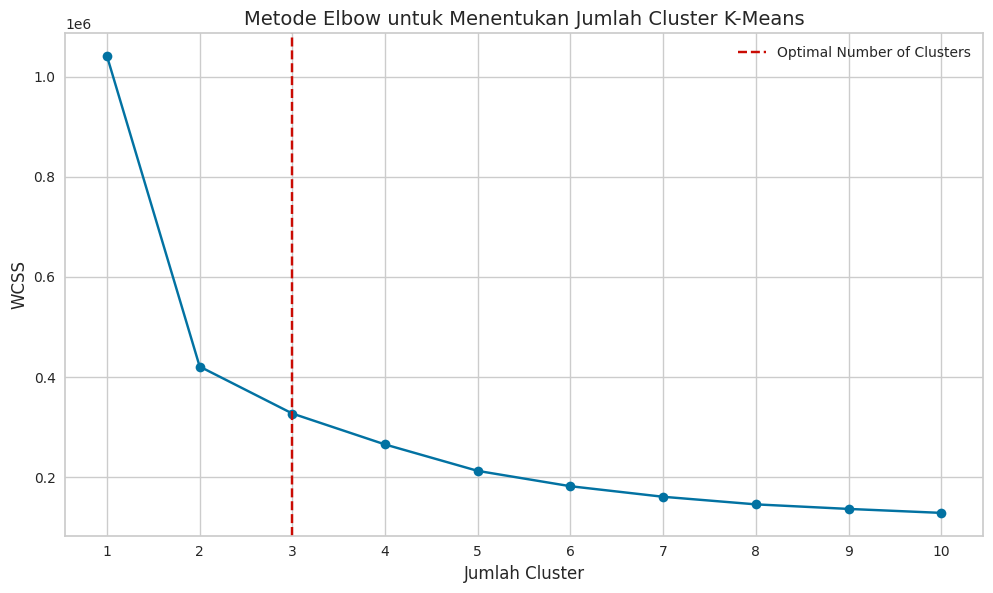

In [ ]:
# Visualisasi Elbow untuk menentukan jumlah cluster optimal
n_clusters = range(1, 11)
wcss = []

# Menggunakan data yang sudah diskalakan
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init=25, random_state=42)
    kmeans.fit(x_model)
    wcss.append(kmeans.inertia_)

# Plot hasil Elbow
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, wcss, marker='o', color='b', linestyle='-')
plt.xlabel('Jumlah Cluster', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster K-Means', fontsize=14)
plt.grid(True)
plt.xticks(n_clusters)
plt.axvline(x=3, color='r', linestyle='--', label='Optimal Number of Clusters')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
sil_score = silhouette_score(x_model, kmeans_labels)
db_score = davies_bouldin_score(x_model, kmeans_labels)

clustering_scores = pd.DataFrame({
    'Clustering Method': 'Kmeans',
    'Silhouette Score': [sil_score],
    'Davies-Bouldin Score': [db_score]
})
clustering_scores

,Clustering Method,Silhouette Score,Davies-Bouldin Score
0,Kmeans,0.348095,1.126077


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [ ]:
features_data = x_model.drop(columns=['Cluster'])

# Melakukan seleksi fitur dengan menggunakan SelectKBest dan mutual_info_classif
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(features_data, kmeans_labels)

# Menampilkan jumlah fitur sebelum dan setelah seleksi
print("Jumlah fitur sebelum seleksi:", features_data.shape[1])
print("Jumlah fitur setelah seleksi:", X_selected.shape[1])

# Menampilkan nama-nama fitur yang terpilih
selected_features = features_data.columns[selector.get_support()]
print("Fitur terpilih setelah seleksi:", selected_features)

Jumlah fitur sebelum seleksi: 17
Jumlah fitur setelah seleksi: 10
Fitur terpilih setelah seleksi: Index(['CustomerAge', 'AccountBalance', 'hours_since_last_trans',
       'TransactionType_Debit', 'trans_year_2024', 'Channel_0', 'Channel_1',
       'CustomerOccupation_0', 'CustomerOccupation_1', 'CustomerOccupation_2'],
      dtype='object')


In [ ]:
# Menentukan jumlah cluster dan parameter lainnya untuk algoritma KMeans
kmeans_model = KMeans(n_clusters=3, n_init=25, random_state=42)

# Menerapkan KMeans pada data terpilih dan mendapatkan label cluster
cluster_labels_selected_features = kmeans_model.fit_predict(X_selected)

# Menghitung metrik evaluasi clustering dengan data yang sudah diseleksi
silhouette_index = silhouette_score(X_selected, cluster_labels_selected_features)
davies_bouldin_index = davies_bouldin_score(X_selected, cluster_labels_selected_features)

# Membuat DataFrame untuk menampilkan hasil evaluasi clustering dengan fitur terpilih
clustering_results_selected = pd.DataFrame({
    'Clustering Technique': ['K-Means (Fitur Terpilih)'],
    'Silhouette Score': [silhouette_index],
    'Davies-Bouldin Score': [davies_bouldin_index]
})

# Menampilkan hasil evaluasi clustering
clustering_results_selected


,Clustering Technique,Silhouette Score,Davies-Bouldin Score
0,K-Means (Fitur Terpilih),0.574285,0.565906


- setelah  melakukan feature selection performa model menunjukkan hasil yang signifikan

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

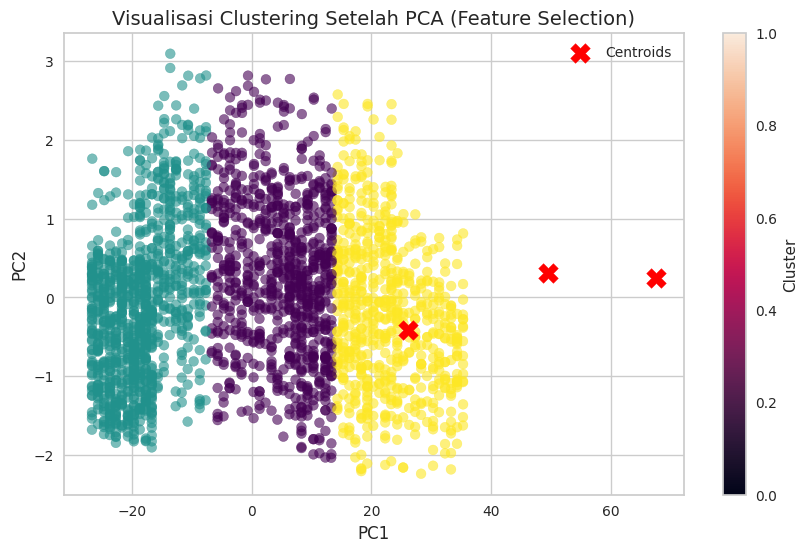

In [ ]:
# Melakukan PCA untuk mereduksi dimensi menjadi 2
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_selected)

# Plot hasil clustering
plt.figure(figsize=(10, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=cluster_labels_selected_features, cmap='viridis', s=50, alpha=0.6)
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('Visualisasi Clustering Setelah PCA (Feature Selection)', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.colorbar(label='Cluster')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


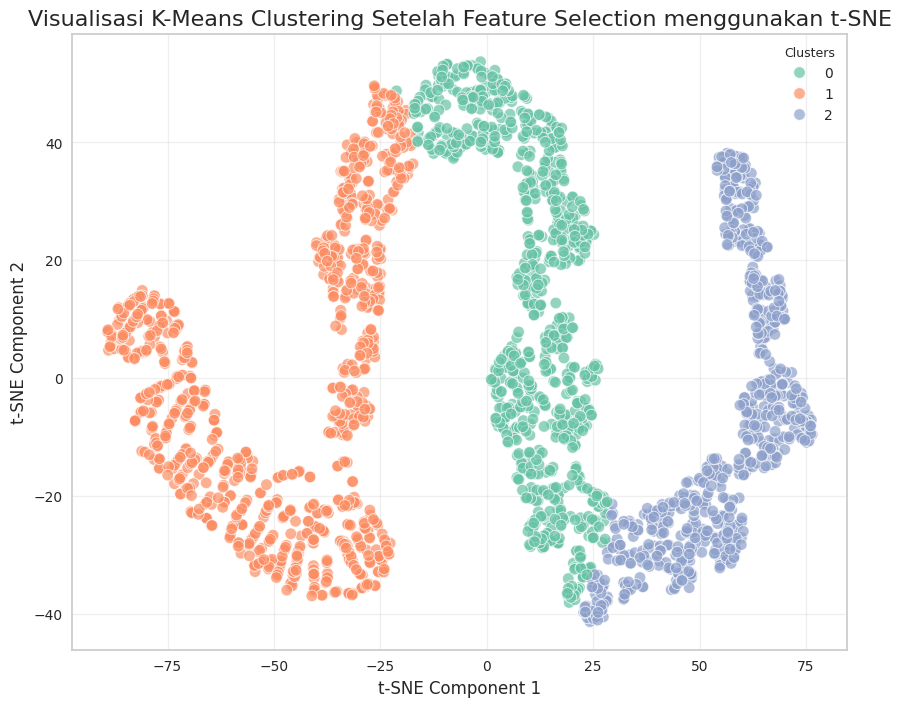

In [ ]:
tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
reduced_features = tsne_model.fit_transform(X_selected)

# Membuat DataFrame dari hasil t-SNE untuk memudahkan visualisasi
tsne_df = pd.DataFrame(reduced_features, columns=['t-SNE 1', 't-SNE 2'])
tsne_df['Cluster'] = cluster_labels_selected_features

# Membuat visualisasi untuk menunjukkan hasil clustering
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2',
    hue='Cluster',
    palette='Set2',
    data=tsne_df,
    alpha=0.7,
    s=70
)

# Menambahkan judul dan label pada grafik
plt.title("Visualisasi K-Means Clustering Setelah Feature Selection menggunakan t-SNE", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Clusters", loc="upper right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

In [ ]:
# Type your code here
normalized_df = cleaned_df.copy()
normalized_df['Cluster'] = cluster_labels_selected_features

In [ ]:
normalized_df.head()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,trans_month,trans_day,trans_hour,trans_dayofweek,hours_since_last_trans,TransactionType_Debit,trans_year_2024,Channel_0,Channel_1,CustomerOccupation_0,CustomerOccupation_1,CustomerOccupation_2,Cluster
0,-0.971275,70,-0.552443,1,-0.000537,4,11,16,1,-0.800762,1.0,0.0,0,1,0,0,1,2
1,0.269440,68,0.305314,1,2.216472,6,27,16,1,-0.076706,1.0,0.0,0,1,0,0,1,2
2,-0.586882,19,-0.909842,1,-1.023534,7,10,18,0,0.046138,1.0,0.0,1,0,0,1,0,1
3,-0.387456,26,-1.353017,1,0.885797,5,5,16,4,-0.575097,1.0,0.0,1,0,0,1,0,1
4,-0.973468,26,1.120184,1,0.593589,10,16,17,0,0.967391,0.0,0.0,1,0,0,1,0,1


### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [ ]:
# Invers data encoding

# invers data One Hot Encoding
ohe_inverse = ohe.inverse_transform(ohe_data)
ohe_inverse_df = pd.DataFrame(ohe_inverse, columns=['TransactionType', 'trans_year'])
normalized_df[['TransactionType', 'trans_year']] = ohe_inverse_df

# invers data Binary Encoding
bin_channel_inverse = bin_encoder_channel.inverse_transform(bin_channel)
normalized_df['Channel'] = bin_channel_inverse['Channel']

bin_occ_inverse = bin_encoder_occ.inverse_transform(bin_occ)
normalized_df['CustomerOccupation'] = bin_occ_inverse['CustomerOccupation']

In [ ]:
# menghapus kolom-kolom yang sudah tidak digunakan
normalized_df.drop(columns=['TransactionType_Debit','trans_year_2024','Channel_0','Channel_1', 'CustomerOccupation_0', 'CustomerOccupation_1', 'CustomerOccupation_2'], inplace=True)
normalized_df.head()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,trans_month,trans_day,trans_hour,trans_dayofweek,hours_since_last_trans,Cluster,TransactionType,trans_year,Channel,CustomerOccupation
0,-0.971275,70,-0.552443,1,-0.000537,4,11,16,1,-0.800762,2,Debit,2023,ATM,Doctor
1,0.269440,68,0.305314,1,2.216472,6,27,16,1,-0.076706,2,Debit,2023,ATM,Doctor
2,-0.586882,19,-0.909842,1,-1.023534,7,10,18,0,0.046138,1,Debit,2023,Online,Student
3,-0.387456,26,-1.353017,1,0.885797,5,5,16,4,-0.575097,1,Debit,2023,Online,Student
4,-0.973468,26,1.120184,1,0.593589,10,16,17,0,0.967391,1,Credit,2023,Online,Student


In [ ]:
# invers data standarization
normalized_df[cols_to_scale] = scaler.inverse_transform(normalized_df[cols_to_scale])

In [ ]:
normalized_df.head()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,trans_month,trans_day,trans_hour,trans_dayofweek,hours_since_last_trans,Cluster,TransactionType,trans_year,Channel,CustomerOccupation
0,14.09,70,81.0,1,5112.21,4,11,16,1,-13743.648333,2,Debit,2023,ATM,Doctor
1,376.24,68,141.0,1,13758.91,6,27,16,1,-11895.421111,2,Debit,2023,ATM,Doctor
2,126.29,19,56.0,1,1122.35,7,10,18,0,-11581.848889,1,Debit,2023,Online,Student
3,184.50,26,25.0,1,8569.06,5,5,16,4,-13167.615278,1,Debit,2023,Online,Student
4,13.45,26,198.0,1,7429.40,10,16,17,0,-9230.254167,1,Credit,2023,Online,Student


In [ ]:
cols = [col for col in normalized_df.columns if col != 'Cluster'] + ['Cluster']
normalized_df = normalized_df[cols]

In [ ]:
normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TransactionAmount       2512 non-null   float64
 1   CustomerAge             2512 non-null   int64  
 2   TransactionDuration     2512 non-null   float64
 3   LoginAttempts           2512 non-null   int64  
 4   AccountBalance          2512 non-null   float64
 5   trans_month             2512 non-null   int32  
 6   trans_day               2512 non-null   int32  
 7   trans_hour              2512 non-null   int32  
 8   trans_dayofweek         2512 non-null   int32  
 9   hours_since_last_trans  2512 non-null   float64
 10  TransactionType         2512 non-null   object 
 11  trans_year              2512 non-null   object 
 12  Channel                 2512 non-null   object 
 13  CustomerOccupation      2512 non-null   object 
 14  Cluster                 2512 non-null   

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

Deskripsi Statistik Numerik berdasarkan Cluster:
        TransactionAmount                                                                 \
                    count        mean         std   min     25%     50%     75%      max   
Cluster                                                                                    
0                   829.0  273.384922  265.105132  0.32  78.930  195.80  391.08  1830.00   
1                  1026.0  310.463070  305.825215  0.26  85.275  215.16  428.81  1919.11   
2                   657.0  308.043166  300.486988  1.82  84.590  224.28  399.21  1831.02   

        CustomerAge                                                    TransactionDuration  \
              count       mean       std   min   25%   50%   75%   max               count   
Cluster                                                                                      
0             829.0  49.442702  6.026164  38.0  44.0  51.0  55.0  58.0               829.0   
1            1026.0  2

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


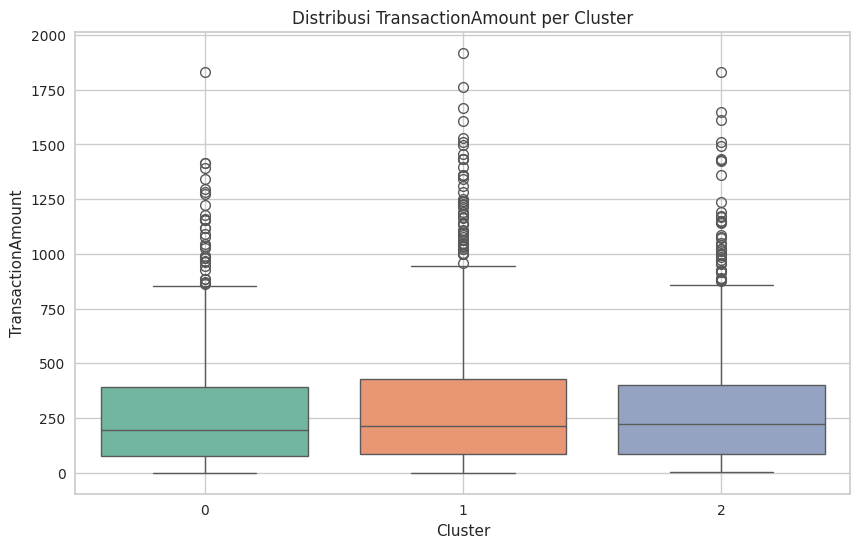

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


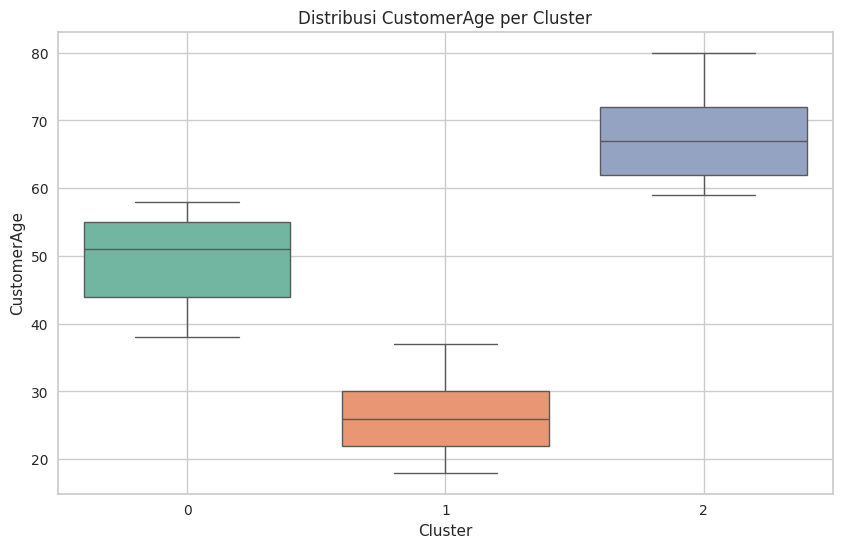

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


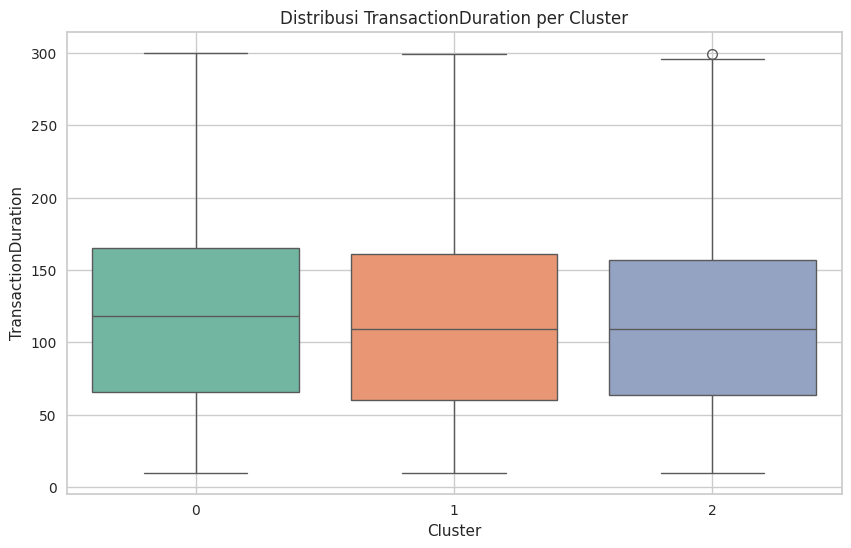

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


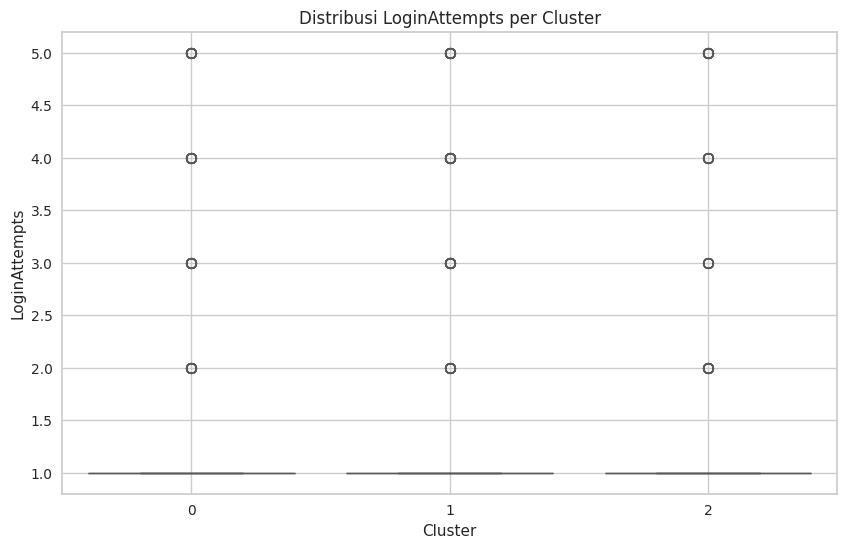

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


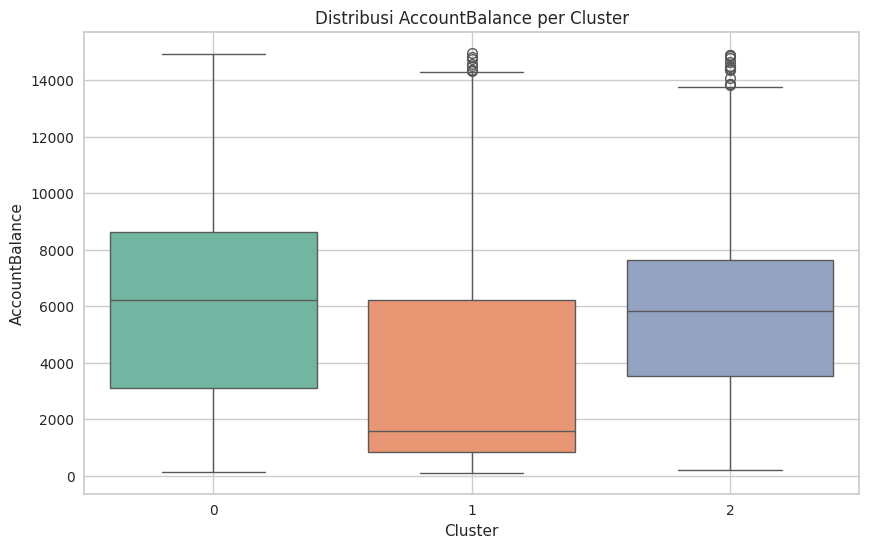

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


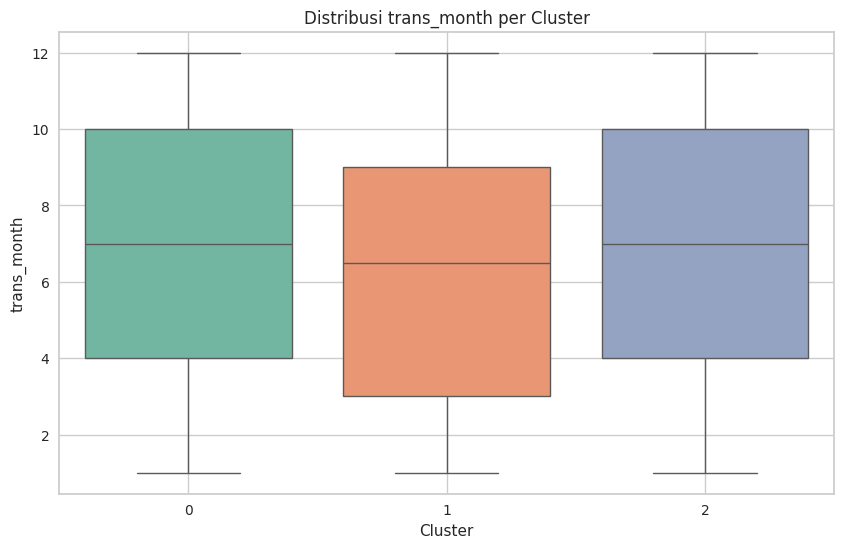

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


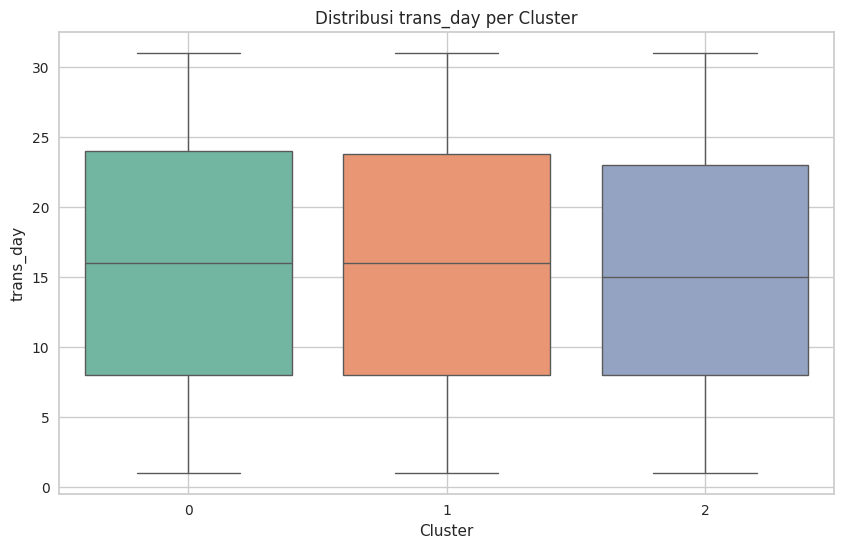

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


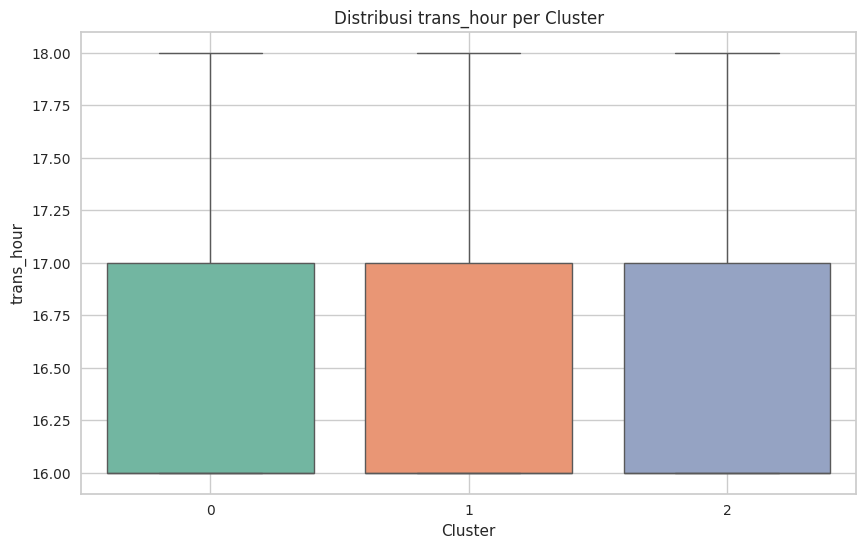

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


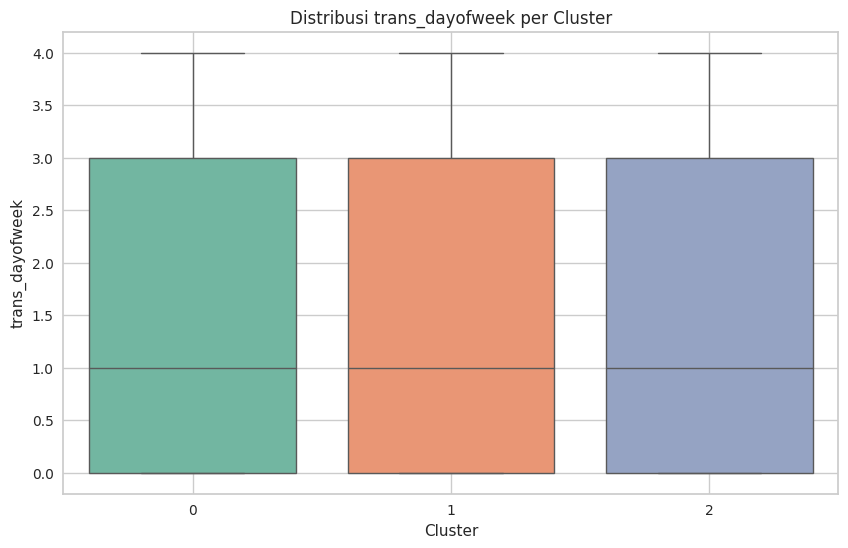

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


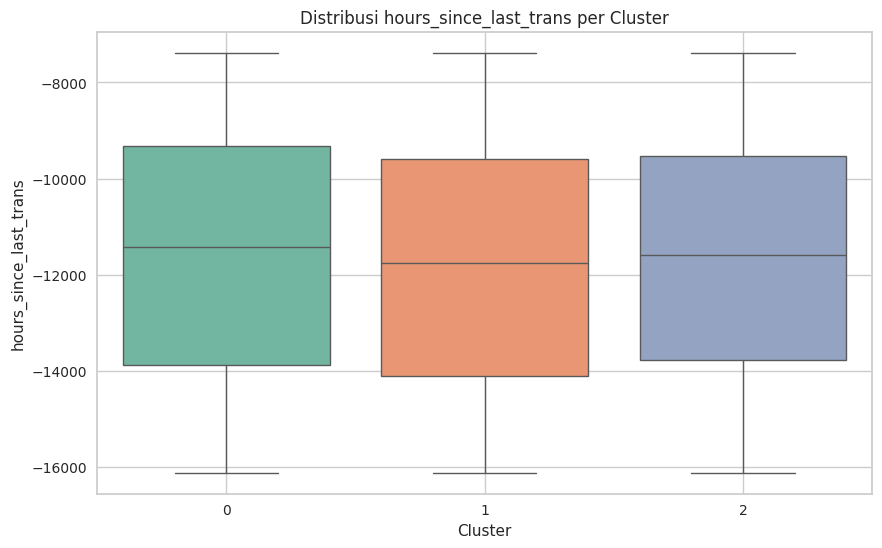

<ipython-input-66-09c3b57bcadb>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')


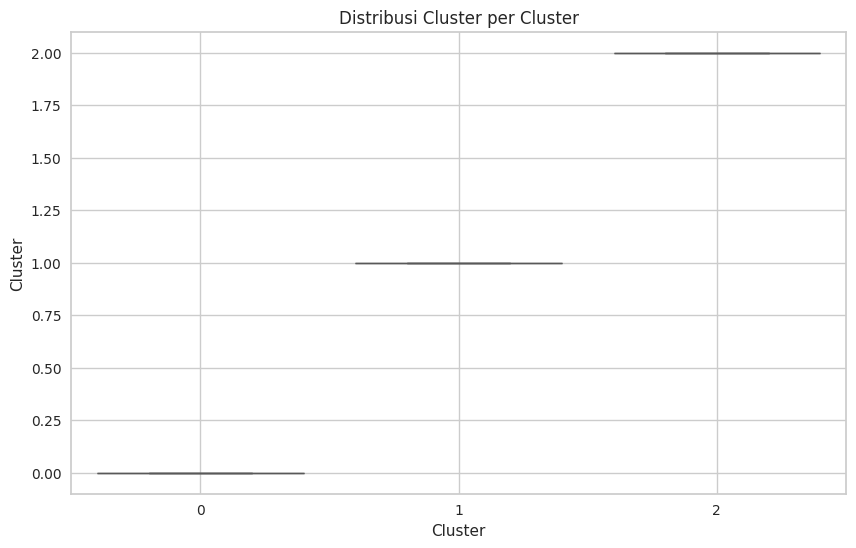

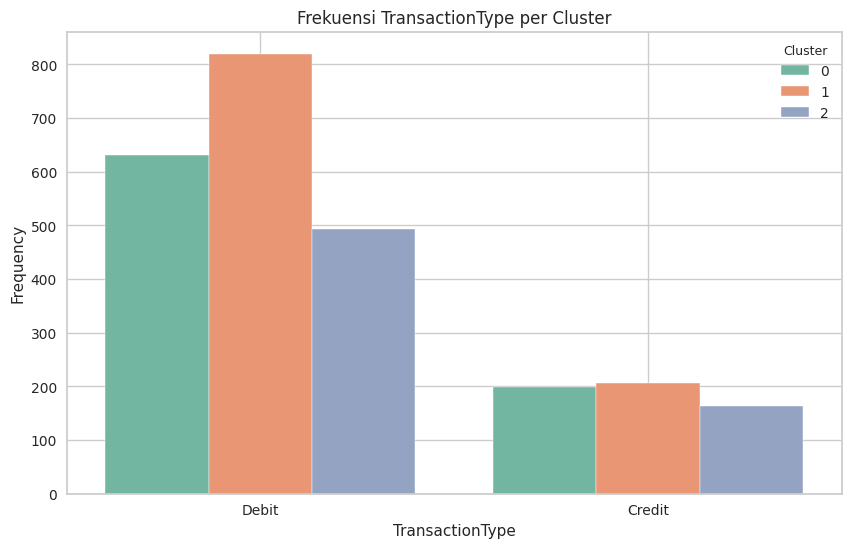

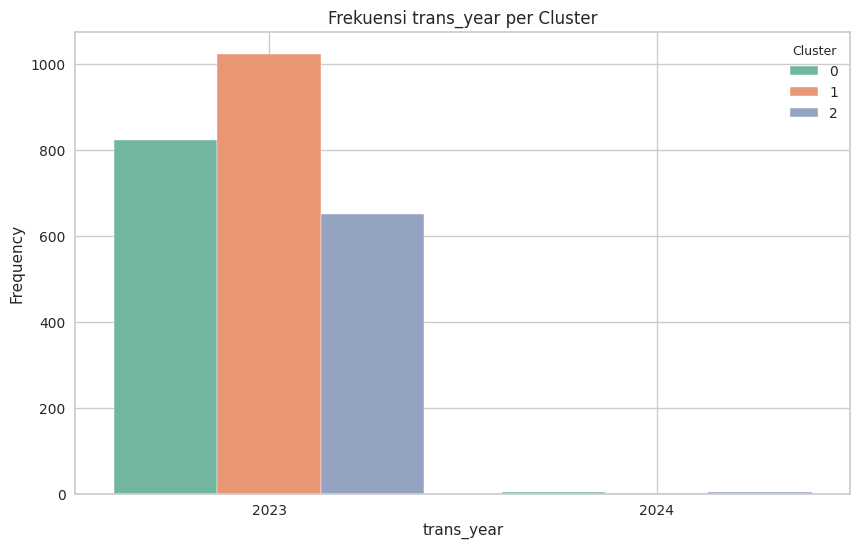

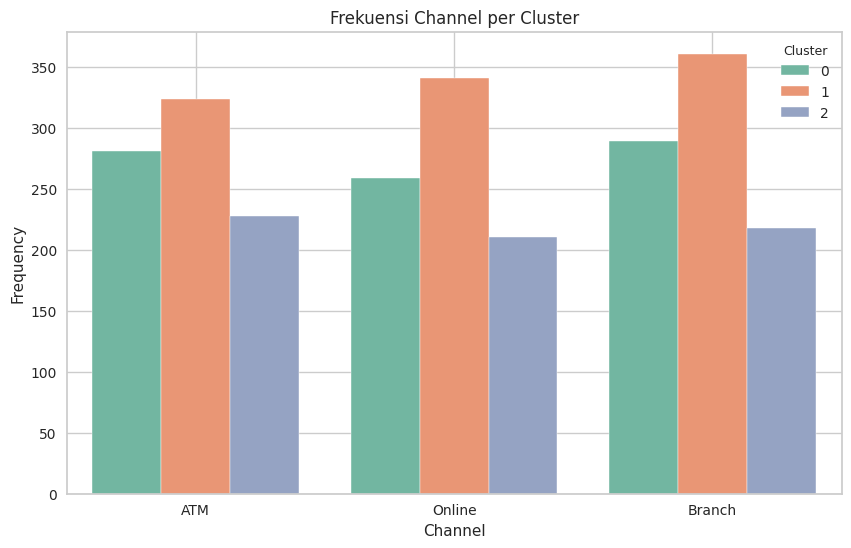

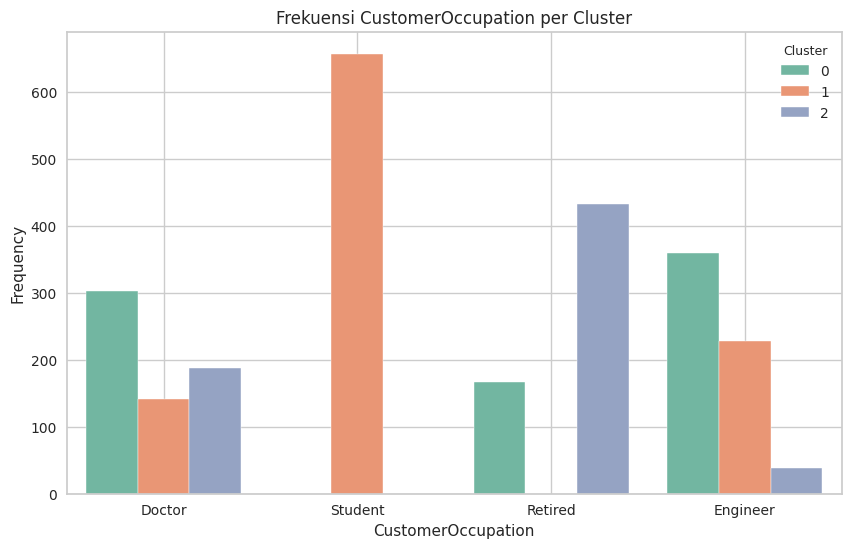

In [ ]:
# Setting tampilan
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

# Statistik Deskriptif Numerik per Cluster
numeric_cols = normalized_df.select_dtypes(include=[np.number]).columns
numeric_stats = normalized_df.groupby('Cluster')[numeric_cols].describe()
print("Deskripsi Statistik Numerik berdasarkan Cluster:")
print(numeric_stats)

# Statistik Deskriptif Kategorikal (Modus per Cluster)
categorical_cols = normalized_df.select_dtypes(include=[object]).columns

print("\nModus Fitur Kategorikal berdasarkan Cluster:")
for col in categorical_cols:
    print(f"\nFitur: {col}")
    modus_per_cluster = normalized_df.groupby('Cluster')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    print(modus_per_cluster)

# Visualisasi Distribusi Fitur Numerik (Boxplot)
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=col, data=normalized_df, palette='Set2')
    plt.title(f'Distribusi {col} per Cluster', fontsize=12)
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

# Visualisasi Frekuensi Fitur Kategorikal (Countplot)
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Cluster', data=normalized_df, palette='Set2')
    plt.title(f'Frekuensi {col} per Cluster', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

Tulis hasil interpretasinya di sini.

# Analisis Karakteristik Cluster dari Model KMeans

## 1. Cluster 1:
  - rata-rata TransactionAmount : 273.384
  - rata-rata usia : 49
  - rata-rata account balance : 6343.607
  - analisis : Nasabah dengan usia dewasa dalam rentang usia sekitar 49 tahun yang memiliki saldo dengan nominal besar namun jumlah transaksi yang sedikit. Nasabah ini cenderung melakukan transaksi pada pertengahan bulan. Cluster ini di dominasi oleh doctor dan Engineer. Transaksi mayoritas dilakukan melalui Branch

## 2. Cluster 2:
  - rata-rata TransactionAmount : 310.463
  - rata-rata usia : 26
  - rata-rata account balance : 3505.803
  - analisis : Nasabah dengan usia muda dalam rentang usia 26 ahun yang memiliki saldo rendah  namun nominal transaksinya cenderung tinggi. Transaksi dilakukan secara merata (bukan awal ataupun akhir bulan). Cluster ini di dominasi oleh Student. Transaksi mayoritas dilakukan melalui Branch

## 3. Cluster 3:
  - rata-rata TransactionAmount : 308.043
  - rata-rata usia : 67
  - rata-rata account balance :  6075.075
  - analisis : Nasabah dengan usia senior dalam rentang usia  sekitar 67 tahun yang memiliki saldo besar dan jumlah transaksi yang besar pula. Cluster ini didominasi oleh retired. Transaksi mayoritas dilakukan melalui ATM


4. Feature yang tidak disebutkan adalah feature yang tidak memiliki batas yang signifikan terhadap setiap cluster
  

# Contoh interpretasi [TEMPLATE]
# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster 1:
- **Rata-rata Annual Income (k$):** 48,260  
- **Rata-rata Spending Score (1-100):** 56.48  
- **Analisis:** Cluster ini mencakup pelanggan dengan pendapatan tahunan menengah dan tingkat pengeluaran yang cukup tinggi. Pelanggan dalam cluster ini cenderung memiliki daya beli yang moderat dan mereka lebih cenderung untuk membelanjakan sebagian besar pendapatan mereka.

## Cluster 2:
- **Rata-rata Annual Income (k$):** 86,540  
- **Rata-rata Spending Score (1-100):** 82.13  
- **Analisis:** Cluster ini menunjukkan pelanggan dengan pendapatan tahunan tinggi dan pengeluaran yang sangat tinggi. Pelanggan di cluster ini merupakan kelompok premium dengan daya beli yang kuat dan cenderung mengeluarkan uang dalam jumlah besar untuk produk atau layanan.

## Cluster 3:
- **Rata-rata Annual Income (k$):** 87,000  
- **Rata-rata Spending Score (1-100):** 18.63  
- **Analisis:** Cluster ini terdiri dari pelanggan dengan pendapatan tahunan yang tinggi tetapi pengeluaran yang rendah. Mereka mungkin memiliki kapasitas finansial yang baik namun tidak terlalu aktif dalam berbelanja. Ini bisa menunjukkan bahwa mereka lebih selektif dalam pengeluaran mereka atau mungkin lebih cenderung untuk menyimpan uang.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [ ]:
normalized_df.to_csv('Dataset_clustering.csv', index=False)
files.download('Dataset_clustering.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>